In [89]:
# підключення базових модулей
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
import shutil
from pprint import pprint

# параметри виведення
pd.set_option("display.max_columns", 500) # кількість колонок
pd.set_option("display.max_rows", 1000) # кількість рядків
pd.set_option("display.max_colwidth", 300) # ширина колонок
pd.set_option("display.precision", 5) # кількість знаків після коми

# вимикаємо зайві попередження
import warnings
warnings.filterwarnings("ignore")

# друк всіх результатів в одній комірці а не тільки останнього
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# магічний метод для того щоб отримувати графіки біля комірок з кодом
%matplotlib inline

In [90]:
# підключення спеціалізованих модулей
import timeit
from functools import lru_cache
import tabulate

In [ ]:
# реалізація класу Splay Tree для зберігання даних "key: value"

class Node:
    def __init__(self, key, value, parent=None):
        self.key = key
        self.value = value
        self.parent = parent
        self.left_node = None
        self.right_node = None


class SplayTree:
    def __init__(self):
        self.root = None

    def insert(self, key, value):
        """Вставка нового елемента в дерево."""
        if self.root is None:
            self.root = Node(key, value)
        else:
            self._insert_node(key, value, self.root)

    def _insert_node(self, key, value, current_node):
        """Рекурсивна вставка елемента в дерево."""
        if key < current_node.key:
            if current_node.left_node:
                self._insert_node(key, value, current_node.left_node)
            else:
                current_node.left_node = Node(key, value, current_node)
        else:
            if current_node.right_node:
                self._insert_node(key, value, current_node.right_node)
            else:
                current_node.right_node = Node(key, value, current_node)

    def find(self, key):
        """Пошук елемента в дереві із застосуванням сплаювання."""
        node = self.root
        while node is not None:
            if key < node.key:
                node = node.left_node
            elif key > node.key:
                node = node.right_node
            else:
                self._splay(node)
                return node.value
        return None  # Якщо елемент не знайдено.

    def _splay(self, node):
        """Реалізація сплаювання для переміщення вузла до кореня."""
        while node.parent is not None:
            if node.parent.parent is None:  # Zig-ситуація
                if node == node.parent.left_node:
                    self._rotate_right(node.parent)
                else:
                    self._rotate_left(node.parent)
            elif (
                node == node.parent.left_node
                and node.parent == node.parent.parent.left_node
            ):  # Zig-Zig
                self._rotate_right(node.parent.parent)
                self._rotate_right(node.parent)
            elif (
                node == node.parent.right_node
                and node.parent == node.parent.parent.right_node
            ):  # Zig-Zig
                self._rotate_left(node.parent.parent)
                self._rotate_left(node.parent)
            else:  # Zig-Zag
                if node == node.parent.left_node:
                    self._rotate_right(node.parent)
                    self._rotate_left(node.parent)
                else:
                    self._rotate_left(node.parent)
                    self._rotate_right(node.parent)

    def _rotate_right(self, node):
        """Права ротація вузла."""
        left_child = node.left_node
        if left_child is None:
            return

        node.left_node = left_child.right_node
        if left_child.right_node:
            left_child.right_node.parent = node

        left_child.parent = node.parent
        if node.parent is None:
            self.root = left_child
        elif node == node.parent.left_node:
            node.parent.left_node = left_child
        else:
            node.parent.right_node = left_child

        left_child.right_node = node
        node.parent = left_child

    def _rotate_left(self, node):
        """Ліва ротація вузла."""
        right_child = node.right_node
        if right_child is None:
            return

        node.right_node = right_child.left_node
        if right_child.left_node:
            right_child.left_node.parent = node

        right_child.parent = node.parent
        if node.parent is None:
            self.root = right_child
        elif node == node.parent.left_node:
            node.parent.left_node = right_child
        else:
            node.parent.right_node = right_child

        right_child.left_node = node
        node.parent = right_child


if __name__ == "__main__":
    # тестування модернізованого Splay Tree
    test_splay_tree = SplayTree()
    test_splay_tree.insert(10, "10+")
    test_splay_tree.insert(8, "8+")
    test_splay_tree.insert(3, "3+")
    test_splay_tree.insert(7, "7+")

    print("Accessing 7:", test_splay_tree.find(7))
    print("Accessing 3:", test_splay_tree.find(3))
    print("Accessing 8:", test_splay_tree.find(8))
    print("Accessing 11:", test_splay_tree.find(11))
    print("Root after operations:", test_splay_tree.root.key)

Accessing 7: 7+
Accessing 3: 3+
Accessing 8: 8+
Accessing 11: None
Root after operations: 8


In [ ]:
# підготовка рядків коду для замірів часу виконання

lru_code_text = """
MAXSIZE = 1000

@lru_cache(maxsize=MAXSIZE)
def fibonacci_lru(n):
    if n < 2:
        return n
    return fibonacci_lru(n - 1) + fibonacci_lru(n - 2)

fibonacci_lru(i)
    """

splay_code_text = """
def fibonacci_splay(n, memo=None):
    if memo is None:
        memo = SplayTree()

    from_memo = memo.find(n)

    if from_memo:
        return from_memo

    if n <= 1:
        return n

    value = fibonacci_splay(n - 1, memo) + fibonacci_splay(n - 2, memo)
    memo.insert(n, value)
    return value

fibonacci_splay(i)
"""

In [109]:
# замірюємо час виконання функцій

# кількість замірів
n = 100

# замір часу виконання функції fibonacci_lru
lru_avg_timer_dict = {}
for i in range(0, 1000, 50):
    dict_timer = timeit.timeit(
        stmt=lru_code_text,
        setup="from __main__ import i, lru_cache",
        number=n,
    )
    lru_avg_timer_dict[i] = dict_timer / n

# замір часу виконання функції fibonacci_splay
splay_avg_timer_dict = {}
for i in range(0, 1000, 50):
    dict_timer = timeit.timeit(
        stmt=splay_code_text,
        setup="from __main__ import i, SplayTree",
        number=n,
    )
    splay_avg_timer_dict[i] = dict_timer / n

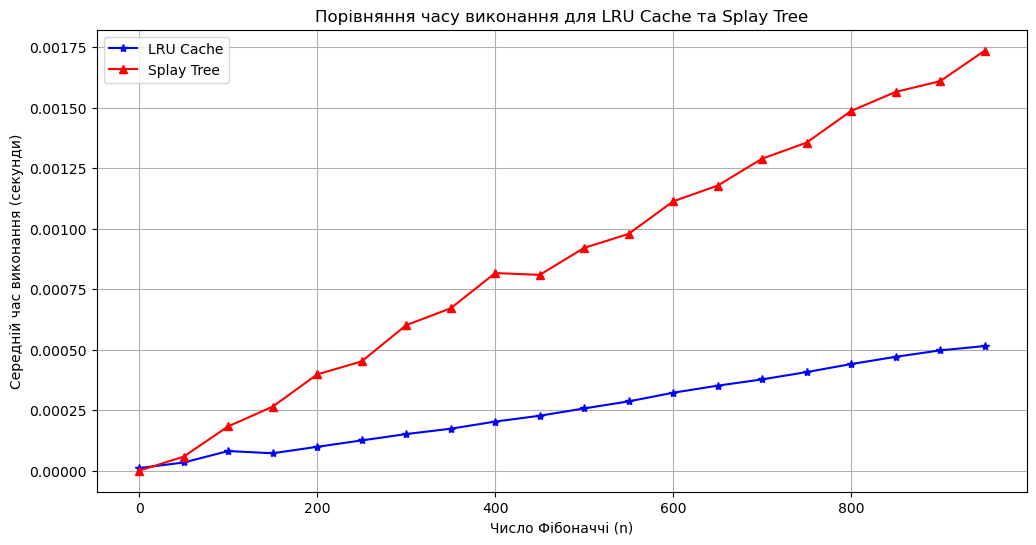

In [110]:
# малюємо графік порівняння часу виконання

# Створюємо дані для осі X
X = list(lru_avg_timer_dict.keys())

# Створюємо дані для осі Y
Y1 = list(lru_avg_timer_dict.values())
Y2 = list(splay_avg_timer_dict.values())

# Створюємо фігуру
plt.figure(figsize=(12, 6))

# Малюємо першу лінію
plt.plot(X, Y1, label="LRU Cache", color="blue", marker='*', linestyle='-',)

# Малюємо другу лінію
plt.plot(X, Y2, label="Splay Tree", color="red", marker='^', linestyle='-',)

# Додаємо заголовок та підписи осей
plt.title("Порівняння часу виконання для LRU Cache та Splay Tree")
plt.xlabel("Число Фібоначчі (n)")
plt.ylabel("Середній час виконання (секунди)")

# Додаємо легенду, щоб позначити лінії
plt.legend()

# Відображаємо сітку
plt.grid(True)

# Показуємо графік
plt.show();

In [111]:
# створюємо таблицю з результатами

# Створюємо заголовки для таблиці
headers = ["n", "LRU Cache Time (s)", "Splay Tree Time (s)"]

# Створюємо таблицю з даними
table_data = []
for i in range(len(X)):
    table_data.append((X[i], f"{Y1[i]:.8f}", f"{Y2[i]:.8f}"))
    
# Виводимо таблицю
print(tabulate.tabulate(table_data, headers=headers, 
                        # tablefmt="grid"
                        ))

  n    LRU Cache Time (s)    Splay Tree Time (s)
---  --------------------  ---------------------
  0            1.148e-05              6.2e-07
 50            3.463e-05              5.893e-05
100            8.188e-05              0.00018377
150            7.276e-05              0.00026528
200            9.943e-05              0.00039841
250            0.00012577             0.00045218
300            0.00015207             0.00060189
350            0.00017404             0.00067134
400            0.00020356             0.00081715
450            0.00022767             0.00080951
500            0.00025794             0.00092098
550            0.00028697             0.00097896
600            0.00032278             0.0011133
650            0.00035195             0.00117821
700            0.0003779              0.00128954
750            0.00040808             0.00135604
800            0.00044123             0.00148683
850            0.00047108             0.00156525
900            0.00049774

Висновки:
---------

1. Кешування за допомогою LRU Cache виявилося суттєво швидшим, ніж Splay Tree.
2. Причини цього (на мою думку) в тому, що при переміщенні/додаванні елемента, що був використаний останнім, LRU Cache виконує операції тільки з першим та останнім елементом двозв'язного списку (перший - додається, останній - видаляється) - складність O(1), тоді як в Splay Tree - перебудовується все дерево - складність O(log n).